In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import pymongo as pm
from collections import Counter, defaultdict
from tqdm import tqdm
import seaborn as sns

## Set database

In [2]:
client = pm.MongoClient('localhost', 27017)
db = client.wyscout
#sorted(db.collection_names())

In [3]:
competitions = db.competitions
players = db.players
#events
ev_all = db.events
ev_nat = db.events_nat
ev_club = db.events_club
ev_it = db.events_Italy
ev_fr = db.events_France
ev_es = db.events_Spain
ev_en = db.events_England
ev_de = db.events_Germany
ev_wc = db.events_World_Cup
ev_eu = db.events_European_Championship
#matches
mt_all = db.matches
mt_nat = db.matches_nat
mt_club = db.matches_club
mt_it = db.matches_Italy
mt_fr = db.matches_France
mt_es = db.matches_Spain
mt_en = db.matches_England
mt_de = db.matches_Germany
mt_wc = db.matches_World_Cup
mt_eu = db.matches_European_Championship

In [4]:
#sorted(db.collection_names())

In [5]:
#get all the possible events and subevents name
ev_name = [n for n in ev_all.distinct('eventName')]
sev_name = [n for n in ev_all.distinct('subEventName') if n != '']
scores = ['score', 'scoreP', 'scoreHT', 'scoreET']
periods = ['1H', '2H', 'ET', 'P']

In [6]:
#the function creates a new collection nameColl, filling it with all documents in colIn which verify the condition cond
def updateCollection ( nameColl, fill = False, colIn = None, cond = { }):
    if fill:
        db.wyscout[nameColl]
        eval('db.' + nameColl).insert_many(colIn.find(cond))
    globals()[nameColl] = eval('db.' + nameColl)

## Temporary Tests

In [16]:
a = [e for e in ev_wc.find({ 'matchId': 2058017, 'tags': { 'id': 101  } })]
print(len(a))
a

11


[{'_id': ObjectId('5da049797eda76fad438a52d'),
  'eventId': 9,
  'subEventName': 'Reflexes',
  'tags': [{'id': 101}, {'id': 1802}],
  'playerId': 135747,
  'positions': [{'y': 100, 'x': 100}, {'y': 61, 'x': 11}],
  'matchId': 2058017,
  'eventName': 'Save attempt',
  'teamId': 9598,
  'matchPeriod': '1H',
  'eventSec': 1080.021191,
  'subEventId': 90,
  'id': 263885739},
 {'_id': ObjectId('5da049797eda76fad438a5a8'),
  'eventId': 10,
  'subEventName': 'Shot',
  'tags': [{'id': 101}, {'id': 401}, {'id': 201}, {'id': 1206}, {'id': 1801}],
  'playerId': 14812,
  'positions': [{'y': 42, 'x': 87}, {'y': 100, 'x': 100}],
  'matchId': 2058017,
  'eventName': 'Shot',
  'teamId': 9598,
  'matchPeriod': '1H',
  'eventSec': 1676.030001,
  'subEventId': 100,
  'id': 263884397},
 {'_id': ObjectId('5da049797eda76fad438a5a9'),
  'eventId': 9,
  'subEventName': 'Reflexes',
  'tags': [{'id': 101}, {'id': 1206}, {'id': 1802}],
  'playerId': 25381,
  'positions': [{'y': 0, 'x': 0}, {'y': 58, 'x': 13}],
 

In [24]:
ev_wc.find_one()

{'_id': ObjectId('5da049717eda76fad4371c2e'),
 'eventId': 8,
 'subEventName': 'Simple pass',
 'tags': [{'id': 1801}],
 'playerId': 122671,
 'positions': [{'y': 50, 'x': 50}, {'y': 53, 'x': 35}],
 'matchId': 2057954,
 'eventName': 'Pass',
 'teamId': 16521,
 'matchPeriod': '1H',
 'eventSec': 1.6562140000000003,
 'subEventId': 85,
 'id': 258612104}

In [64]:
print('TEAM\tPLAYER\tEVENT')
for bb in [e for e in ev_wc.find({ 'matchId': 2058017, 'tags': { '$elemMatch': { 'id': { '$in': [101,102] } } }, 'eventName': { '$nin': ['Save attempt'] }  }, { '_id':0 , 'eventName':1, 'subEventName':1, 'teamId':1, 'playerId':1, 'tags':1} )]:
    print('%s\t%s\t%s\t\t\t%s' %(bb['teamId'], bb['playerId'], bb['eventName'], bb['tags']))

TEAM	PLAYER	EVENT
9598	14943	Others on the ball			[{'id': 102}, {'id': 1401}, {'id': 1801}]
9598	14812	Shot			[{'id': 101}, {'id': 401}, {'id': 201}, {'id': 1206}, {'id': 1801}]
4418	3682	Free Kick			[{'id': 101}, {'id': 401}, {'id': 1205}, {'id': 1801}]
4418	7936	Shot			[{'id': 101}, {'id': 401}, {'id': 201}, {'id': 1204}, {'id': 1801}]
4418	353833	Shot			[{'id': 101}, {'id': 402}, {'id': 201}, {'id': 1205}, {'id': 1801}]
9598	14943	Shot			[{'id': 101}, {'id': 402}, {'id': 201}, {'id': 1205}, {'id': 1801}]


In [26]:
mt_wc.find_one({'wyId': 2058017})

{'_id': ObjectId('5da071cf08feb7deb9165fab'),
 'status': 'Played',
 'roundId': 4165368,
 'gameweek': 0,
 'teamsData': {'9598': {'scoreET': 0,
   'coachId': 122788,
   'side': 'away',
   'teamId': 9598,
   'score': 2,
   'scoreP': 0,
   'hasFormation': 1,
   'formation': {'bench': [{'playerId': 69964,
      'assists': '0',
      'goals': 'null',
      'ownGoals': '0',
      'redCards': '0',
      'yellowCards': '0'},
     {'playerId': 69353,
      'assists': '0',
      'goals': 'null',
      'ownGoals': '0',
      'redCards': '0',
      'yellowCards': '0'},
     {'playerId': 212604,
      'assists': '0',
      'goals': 'null',
      'ownGoals': '0',
      'redCards': '0',
      'yellowCards': '0'},
     {'playerId': 69400,
      'assists': '0',
      'goals': 'null',
      'ownGoals': '0',
      'redCards': '0',
      'yellowCards': '0'},
     {'playerId': 230626,
      'assists': '0',
      'goals': 'null',
      'ownGoals': '0',
      'redCards': '0',
      'yellowCards': '0'},
     {

In [35]:
print('TEAM\tPLAYER\tEVENT')
for bb in [e for e in ev_wc.find({ 'matchId': 2058016, 'tags': { 'id': 101  }  }, { '_id':0 , 'eventName':1, 'subEventName':1, 'teamId':1, 'playerId':1} )]:
    print('%s\t%s\t%s\t%s' %(bb['teamId'], bb['playerId'], bb['eventName'], bb['subEventName']))

TEAM	PLAYER	EVENT
5629	37824	Shot	Shot
2413	10131	Save attempt	Reflexes
5629	25707	Shot	Shot
2413	10131	Save attempt	Reflexes


In [30]:
mt_wc.find_one({'wyId': 2058016})

{'_id': ObjectId('5da071cf08feb7deb9165fac'),
 'status': 'Played',
 'roundId': 4165367,
 'gameweek': 0,
 'teamsData': {'2413': {'scoreET': 0,
   'coachId': 276858,
   'side': 'away',
   'teamId': 2413,
   'score': 0,
   'scoreP': 0,
   'hasFormation': 1,
   'formation': {'bench': [{'playerId': 346101,
      'assists': '0',
      'goals': 'null',
      'ownGoals': '0',
      'redCards': '0',
      'yellowCards': '0'},
     {'playerId': 7945,
      'assists': '0',
      'goals': 'null',
      'ownGoals': '0',
      'redCards': '0',
      'yellowCards': '0'},
     {'playerId': 7964,
      'assists': '0',
      'goals': 'null',
      'ownGoals': '0',
      'redCards': '0',
      'yellowCards': '0'},
     {'playerId': 8094,
      'assists': '0',
      'goals': 'null',
      'ownGoals': '0',
      'redCards': '0',
      'yellowCards': '0'},
     {'playerId': 8277,
      'assists': '0',
      'goals': 'null',
      'ownGoals': '0',
      'redCards': '0',
      'yellowCards': '0'},
     {'play

In [97]:
print('TEAM\tPLAYER\tEVENT')
bb =  ev_wc.find_one({'tags': { '$elemMatch': { 'id': { '$gt': 501, '$lte': 504 } } }, 'eventName': { '$nin': ['Save attempt'] }  }, { '_id':0 , 'eventName':1, 'subEventName':1, 'teamId':1, 'playerId':1, 'tags':1} )
print('%s\t%s\t%s\t%s\t\t\t%s' %(bb['teamId'], bb['playerId'], bb['eventName'], bb['subEventName'], bb['tags']))

TEAM	PLAYER	EVENT
14358	101699	Duel	Ground defending duel			[{'id': 504}, {'id': 702}, {'id': 1801}]


In [99]:
print('TEAM\tPLAYER\tEVENT')
bb =  ev_all.find_one({'tags': { '$elemMatch': { 'id': 1601 } }, 'eventName': { '$nin': ['Save attempt'] }  }, { '_id':0 , 'eventName':1, 'subEventName':1, 'teamId':1, 'playerId':1, 'tags':1} )
print('%s\t%s\t%s\t%s\t\t\t%s' %(bb['teamId'], bb['playerId'], bb['eventName'], bb['subEventName'], bb['tags']))

TEAM	PLAYER	EVENT
14358	101699	Duel	Ground defending duel			[{'id': 504}, {'id': 1601}, {'id': 701}, {'id': 1802}]


# Anlaysis for different periods

In [100]:
updateCollection(nameColl='ev_wc_1H') #all World Cup events happened in the first half of each match
updateCollection(nameColl='ev_wc_2H') #all World Cup events happened in the second half of each match
#updateCollection(nameColl='ev_1H')#, fill=True, colIn=ev, cond={'matchPeriod': '1H'} )

In [101]:
#get the ids of the matches in the dataframe df
def get_matches_ids (df):
    return sorted([m['wyId'] for m in df.find({ }, {'_id':0, 'wyId':1})])

In [102]:
# mt = collection of matches
# ev = collection of events
# get_num_events (mt_wc, ev_wc) return the number of events find in ev_wc for each team in each match of mt_wc for the World Cup competition 

def get_num_events (mt, ev):
    new_docs = []
    mt_ids = get_matches_ids (mt)
    for m in tqdm(mt_ids):
        match = mt.find_one({'wyId': m})
        #ev_mt = [e for e in ev.find({'wyId': m})]
        '''
        matchPer = match['duration']
        periods = ['1H', '2H']
        if machPer == 'Extratime':
            periods.append('ET')
        if matchPer == 'Penalities':
            periods.append('P')
        '''
        teamIds = match['teamsData']
        for t in teamIds:
            #scores
            scores_dict = { k:match['teamsData'][t][k] for k in scores }
            scores_dict.update({
                'score2H': scores_dict['score'] - scores_dict['scoreHT'],
                'score1H': scores_dict['scoreHT']
            })
            if scores_dict['scoreET'] > 0:
                scores_dict.update({ 'scoreET': scores_dict['scoreET'] - scores_dict['score'] })
                
            for p in periods:
                #find all the events made in pretiod p
                if p == 'ET':
                    ev_tm = [e for e in ev.find({'matchId': int(m), 'teamId': int(t), 'matchPeriod': { '$in': ['E1', 'E2'] }})]
                else:
                    ev_tm = [e for e in ev.find({'matchId': int(m), 'teamId': int(t), 'matchPeriod': p})]
                
                sev_cnt = Counter([e['subEventName'] for e in ev_tm if e['subEventName'] != '']) #number of each event
                ev_cnt = Counter([e['eventName'] for e in ev_tm if e['eventName'] != '']) #number of each subevent
                
                new_docs.append({'matchId': m, 'teamId': t, 'period': p, 'score': scores_dict['score'+p] , **ev_cnt, **sev_cnt})
    
    return new_docs

In [103]:
#db.wyscout['info_wc']
info_wc = db.info_wc
#info_wc.insert_many(get_num_events(mt_wc, ev_wc))
info_wc.count_documents({ }) #must be 512

512

In [205]:
'''
db.wyscout['info_all']
info_all = db.info_all
info_all.insert_many(get_num_events(mt_all, ev_all))
info_all.count_documents({ }) #must be 7764
'''

"\ndb.wyscout['info_all']\ninfo_all = db.info_all\ninfo_all.insert_many(get_num_events(mt_all, ev_all))\ninfo_all.count_documents({ }) #must be 7764\n"

In [104]:
def infoDataFrame (coll):
    #df is a dataframe that store the matchId, teamId, period, score and the number of each event and subevent for each period and team in each match
    col = [k for k in coll.find_one({ }, {'_id':0}).keys()]
    df = pd.DataFrame(columns= col)
    for d in [e for e in coll.find({ }, {'_id':0})]:
        df = df.append(d, ignore_index=True)
    df = df.fillna(0)
    return df

# Dataframe with the informations of the first half

In [106]:
df = infoDataFrame(info_wc)
df.head()

,matchId,teamId,period,score,Duel,Pass,Free Kick,Others on the ball,Foul,Shot,...,Reflexes,Save attempt,Goalkeeper leaving line,Penalty,Late card foul,Violent Foul,Out of game foul,Protest,Time lost foul,Simulation
0,2057954,14358,1H,2,111,145,4,32,7,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2057954,14358,2H,3,110,166,4,30,15,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2057954,14358,ET,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2057954,14358,P,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2057954,16521,1H,0,124,263,6,35,3,4,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
res = df[df['period']=='1H']
res.head(5)

,matchId,teamId,period,score,Duel,Pass,Free Kick,Others on the ball,Foul,Shot,...,Reflexes,Save attempt,Goalkeeper leaving line,Penalty,Late card foul,Violent Foul,Out of game foul,Protest,Time lost foul,Simulation
0,2057954,14358,1H,2,111,145,4,32,7,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2057954,16521,1H,0,124,263,6,35,3,4,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2057955,16129,1H,0,108,222,2,33,2,3,...,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,2057955,15670,1H,0,102,276,1,57,3,5,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,2057956,14358,1H,0,124,207,3,46,3,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Percentage of ball possession 

In [159]:
#the following code add the column 'percBallPoss' to the dataframe res
matchIds = [i for i in set(res['matchId'])]
tot_ev = dict()
for m in matchIds:
    tot_ev.update({m: res[res['matchId']==m].sum()[ev_name].sum()})
    
newCol = []
for ind, r in res.iterrows():
    m = r['matchId']
    t = r['teamId']
    val = res[(res['matchId']==m) & (res['teamId']==t)].sum()[ev_name].sum()
    newCol.append(val/tot_ev[m]*100)
    
res['percBallPoss'] = newCol

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [109]:
len(res)

128

In [177]:
res = res.drop(columns=['Simulation'])

## Correlation

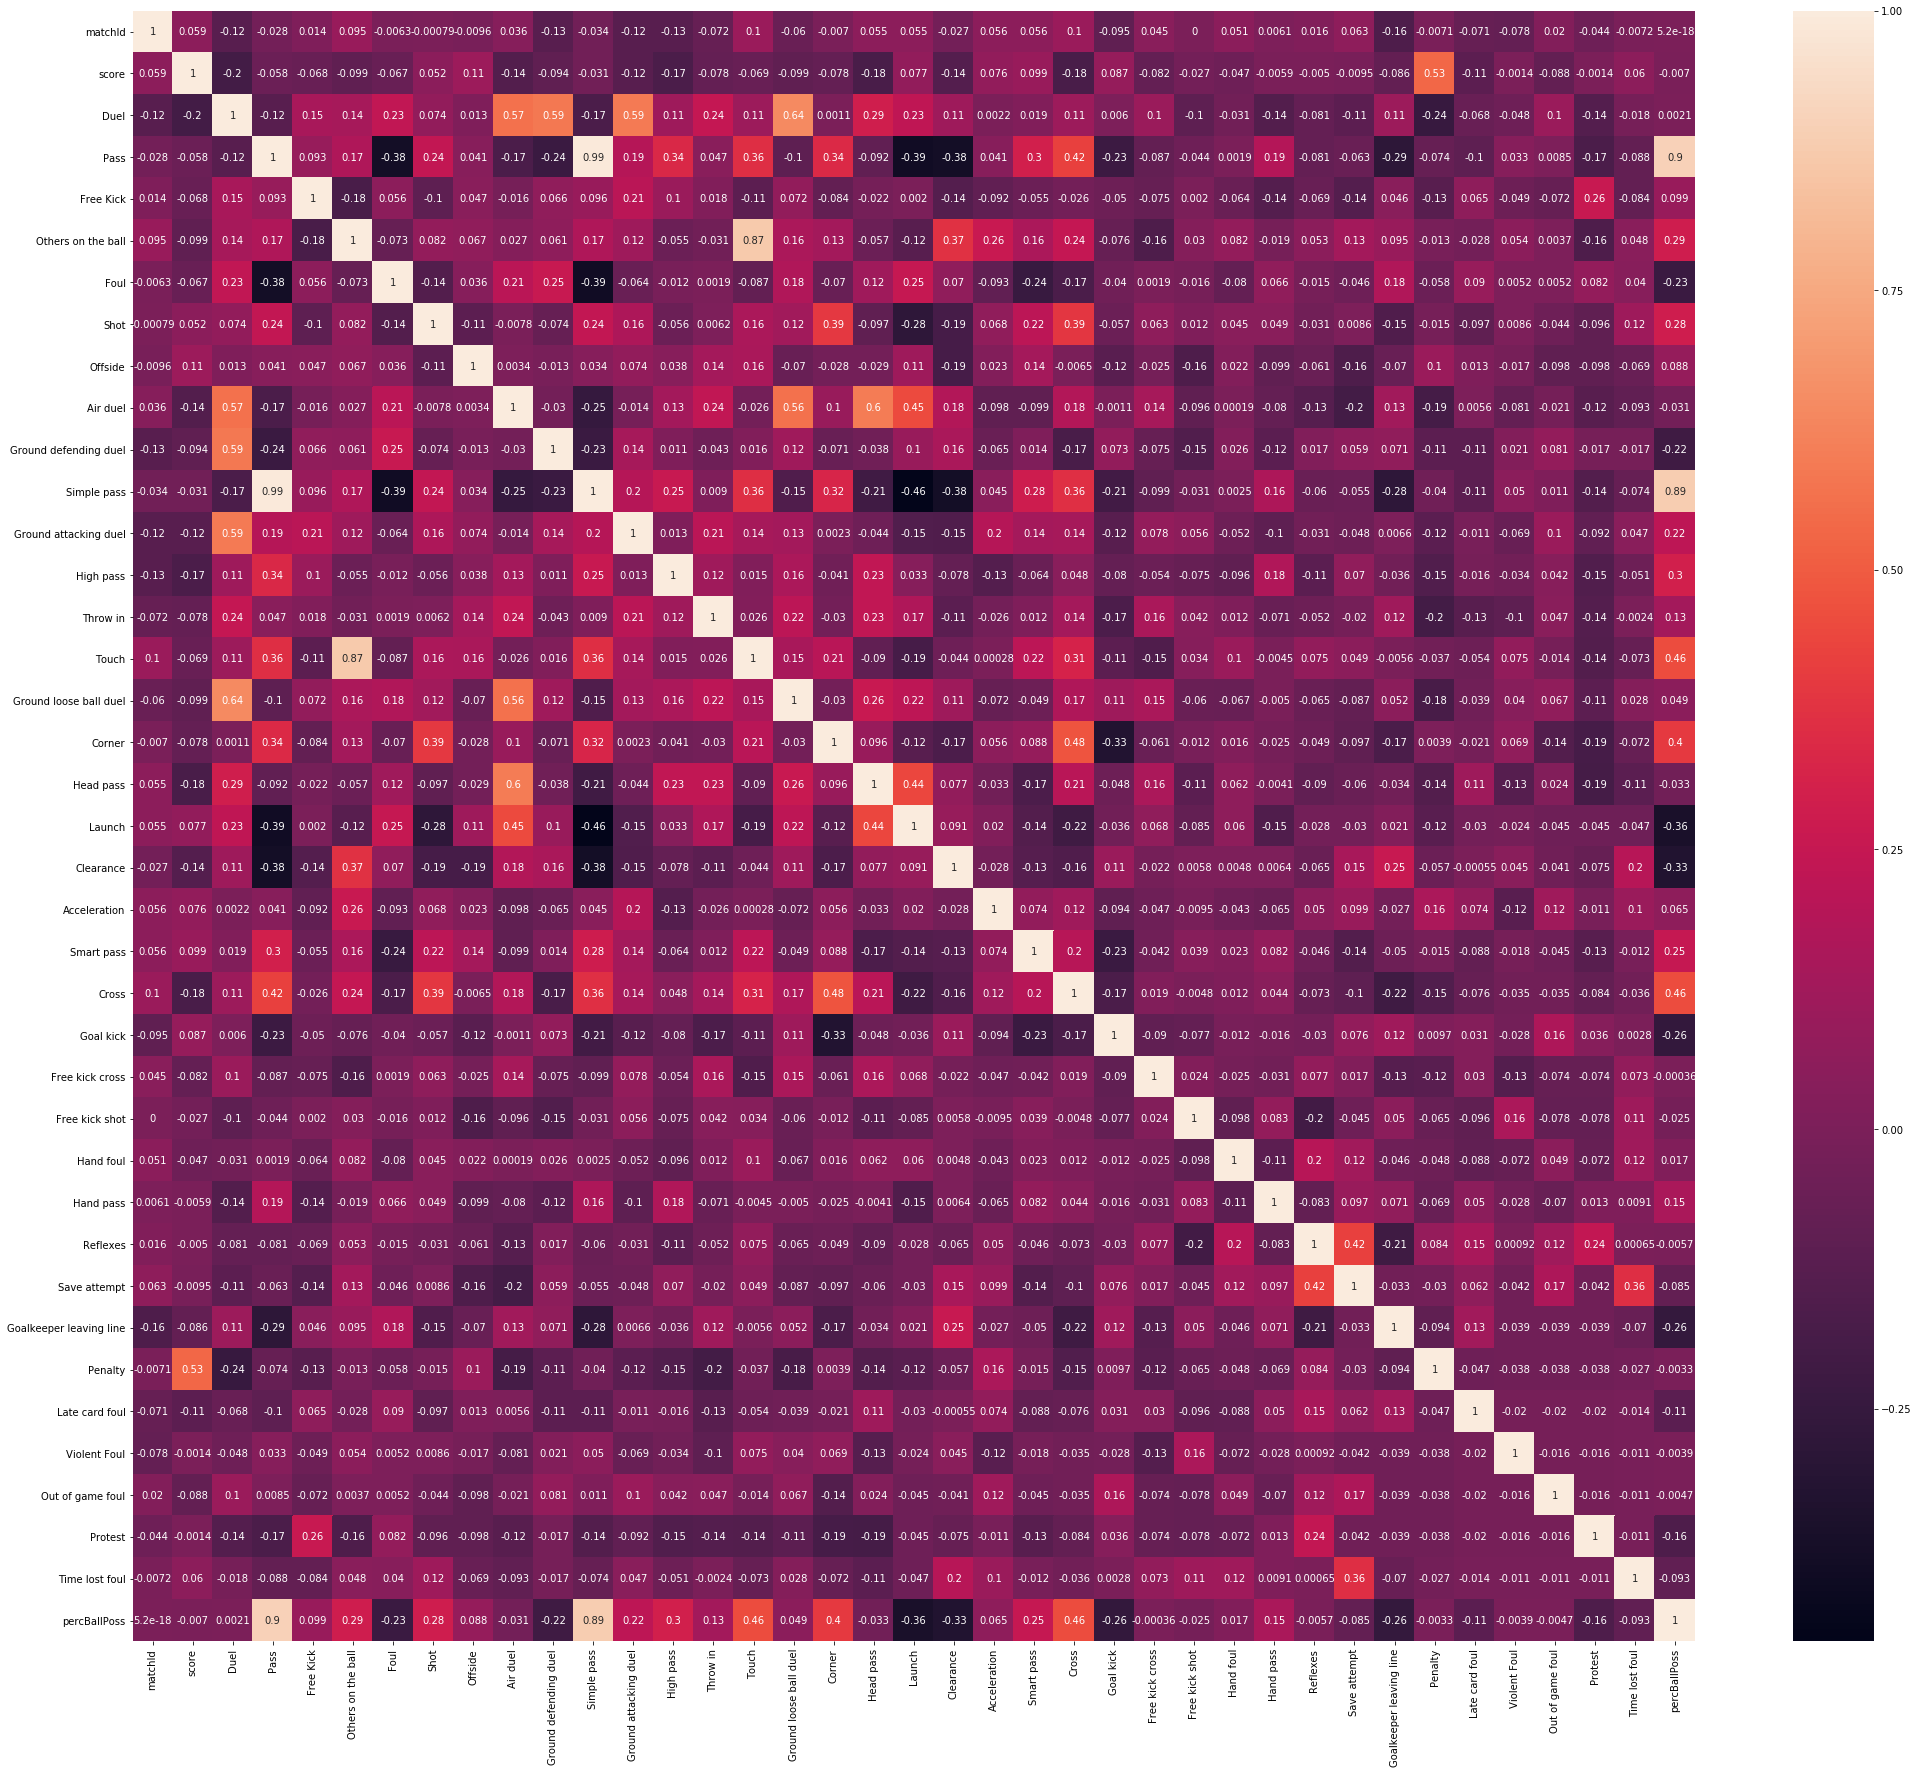

In [180]:
corr = res.corr()
plt.subplots(figsize =(35, 30))
hm = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

# Plot

## Events percentage

In [73]:
#return a data frame (rows = events/subevents, columns= perdios) that store the NUMBER of each event
def cntDataFrame (df, evList):
    df_cnt = pd.DataFrame(columns=periods, index=evList)
    for p in periods:
        df_p = df[df['period']==p].sum()
        for e in evList:
            if e in df_p.index:
                df_cnt[p][e] = df_p[e]
            else:
                df_cnt[p][e] = 0
    return df_cnt

#return a data frame (rows = events/subevents, columns= perdios) that store the PERCENTAGE of each event
def percDataFrame (df):
    df_perc = pd.DataFrame(columns=periods, index=df.index)
    tot = df.sum()
    for p in periods:
        df_perc[p] = df[p]/tot[p]*100
    return df_perc

#return the plot of the events happened in the different periods
def plotEvForPeriod (df, xLen, yLen):
    labels = df.index
    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(xLen, yLen))
    ax.bar(x - 3*width/2, df['1H'], width, label='1H')
    ax.bar(x - width/2, df['2H'], width, label='2H')
    ax.bar(x + width/2, df['ET'], width, label='ET')
    ax.bar(x + 3*width/2, df['P'], width, label='P')

    ax.set_ylabel('Percentage of event in period')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    ax.legend()
    
    #plt.tight_layout()
    plt.show()
    #fig.savefig('prova.pdf')

In [74]:
df_evCnt = cntDataFrame(df, ev_name)
df_evPerc = percDataFrame(df_evCnt)
df_sevCnt = cntDataFrame(df, sev_name)
df_sevPerc = percDataFrame(df_sevCnt)

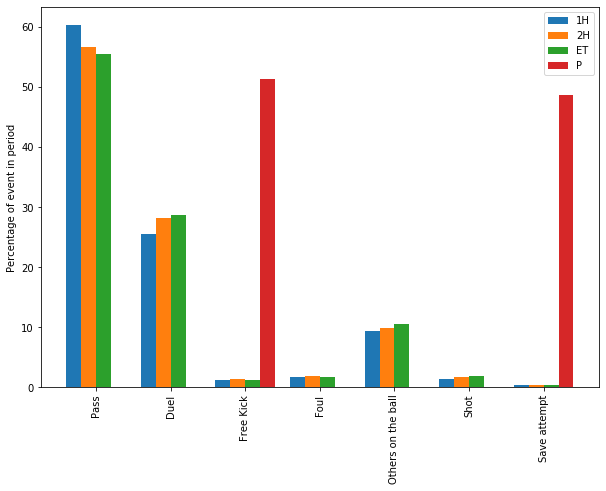

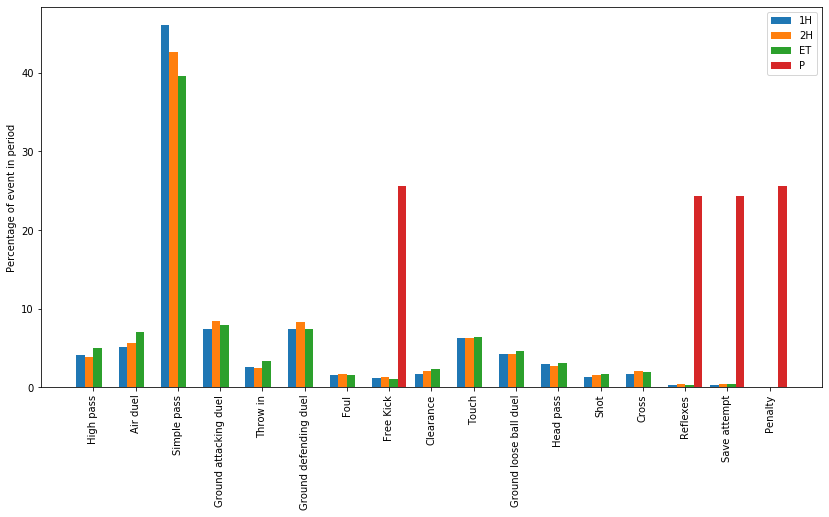

In [504]:
plotEvForPeriod(df_evPerc[(df_evPerc.values).sum(axis=1) > 4], 10, 7)
plotEvForPeriod(df_sevPerc[(df_sevPerc.values).sum(axis=1) > 4], 14, 7)

# Old

In [10]:
# mt = collection of matches
# ev = collection of events
# get_num_events (mt_wc, ev_wc) return the number of events find in ev_wc for each team in each match of mt_wc for the World Cup competition 
def get_num_events (mt, ev):
    new_docs = []
    mt_ids = get_matches_ids (mt)
    for m in tqdm(mt_ids):
        match = mt.find_one({'wyId': m})
        #ev_mt = [e for e in ev.find({'wyId': m})]
        teamIds = match['teamsData']
        for t in teamIds:
            #scores
            scores = ['score', 'scoreP', 'scoreHT', 'scoreET']
            scores_dict = { k:match['teamsData'][t][k] for k in scores }
            scores_dict.update({'score2HT': scores_dict['score'] - scores_dict['scoreHT'] })
            #events
            ev_tm = [e for e in ev.find({'matchId': int(m), 'teamId': int(t)})]
            sev_cnt = Counter([e['subEventName'] for e in ev_tm if e['subEventName'] != '']) #number of each event
            ev_cnt = Counter([e['eventName'] for e in ev_tm if e['eventName'] != '']) #number of each subevent
            
            new_docs.append({'matchId': m, 'teamId': t, **scores_dict, **ev_cnt, **sev_cnt})
    
    return new_docs

In [11]:
#db.wyscout['info_mt_wc']
info_mt_wc = db.info_mt_wc
#info_mt_wc.insert_many(get_num_events(mt_wc, ev_wc))

In [13]:
col = [k for k in info_mt_wc.find_one({ }, {'_id':0}).keys()]
df = pd.DataFrame(columns= col)
for d in [e for e in info_mt_wc.find({ }, {'_id':0})]:
    df = df.append(d, ignore_index=True)
df = df.fillna(0)
df.head()

,matchId,teamId,score,scoreP,scoreHT,scoreET,score2HT,Duel,Pass,Free Kick,...,Reflexes,Save attempt,Goalkeeper leaving line,Penalty,Late card foul,Violent Foul,Out of game foul,Protest,Time lost foul,Simulation
0,2057954,14358,5,0,2,0,3,221,311,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2057954,16521,0,0,0,0,0,247,516,15,...,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2057955,16129,0,0,0,0,0,227,421,6,...,3.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2057955,15670,1,0,0,0,1,219,579,6,...,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2057956,14358,3,0,0,0,3,259,385,6,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Old plots

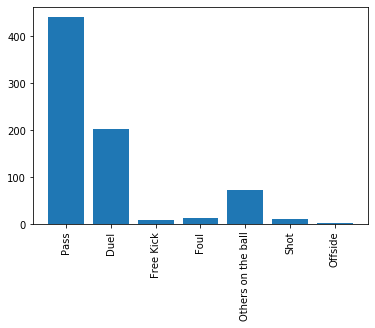

In [197]:
res = dict()
ks = info_mt_wc.find_one().keys()
for k in ks:
    s = '$'+k
    val = [e for e in info_mt_wc.aggregate( [ { '$group' : { '_id':'', 'avg': { '$avg': s } } } ] )][0]['avg']
    res.update({k:val})
    
plt.bar([k for k in ev_name if k in res.keys()], [res[k] for k in ev_name if k in res.keys()])
plt.xticks(rotation='vertical')
plt.show()

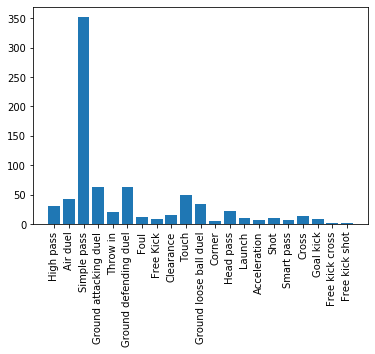

In [198]:
res = dict()
ks = info_mt_wc.find_one().keys()
for k in ks:
    s = '$'+k
    val = [e for e in info_mt_wc.aggregate( [ { '$group' : { '_id':'', 'avg': { '$avg': s } } } ] )][0]['avg']
    res.update({k:val})
    
plt.bar([k for k in sev_name if k in res.keys()], [res[k] for k in sev_name if k in res.keys()])
plt.xticks(rotation='vertical')
plt.show()

## Events with only one position

In [13]:
one_pos_evs = [e for e in tqdm(ev.find()) if len(e['positions'])==1]
db.wyscout['onePosEvs']
onePosEvs = db.onePosEvs
onePosEvs.insert_many(one_pos_evs)

3251294it [02:12, 24510.87it/s]
